# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [2]:
try:
    import prettytable
except ImportError:
    !pip install prettytable
    import prettytable

from prettytable import PrettyTable

In [3]:
try:
    geo_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
    
except FileNotFoundError:
    print("File not found")

In [4]:
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
display(geo_0.isna().sum())
display(geo_1.isna().sum())
geo_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
geo_0['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

In [9]:
geo_1['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [10]:
geo_2['product'].describe()

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

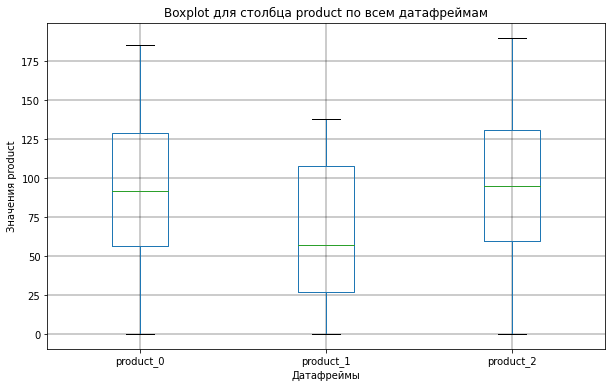

In [11]:
products_cols = pd.DataFrame({
    'product_0': geo_0['product'],
    'product_1': geo_1['product'],
    'product_2': geo_2['product'],
})

# Построение графика boxplot
plt.figure(figsize=(10, 6))
products_cols.boxplot()
plt.title('Boxplot для столбца product по всем датафреймам')
plt.xlabel('Датафреймы')
plt.ylabel('Значения product')
plt.grid(True, color='black', linewidth=0.4)
plt.show()

In [12]:
geo_0_no_id = geo_0.drop(columns=('id'))
geo_1_no_id = geo_1.drop(columns=('id'))
geo_2_no_id = geo_2.drop(columns=('id'))

In [13]:
geo_0.count()

id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [14]:
geo_1.count()

id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [15]:
geo_2.count()

id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

1. Необходимые библиотеки были импортированы для работы.
2. Данные были загружены из трех источников:
   - `geo_0` - https://code.s3.yandex.net/datasets/geo_data_0.csv
   - `geo_1` - https://code.s3.yandex.net/datasets/geo_data_1.csv
   - `geo_2` - https://code.s3.yandex.net/datasets/geo_data_2.csv
3. Проведена проверка загруженных данных на наличие пропущенных значений и выбросы с использованием графиков boxplot.
4. Объявлены переменные, в которых удалены столбцы `id` из исходных датафреймов:
   - `geo_0_no_id`
   - `geo_1_no_id`
   - `geo_2_no_id`

## Обучение и проверка модели

In [16]:
RANDOM_STATE = 42
TEST_SIZE = 0.25 

In [17]:
results_for_2 = []

for train_geo, test_geo in zip([geo_0_no_id, geo_1_no_id, geo_2_no_id], [geo_0_no_id, geo_1_no_id, geo_2_no_id]):
    X_train = train_geo.drop('product', axis=1)
    y_train = train_geo['product']
    
    X_test = test_geo.drop('product', axis=1)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    results_for_2.append(pd.DataFrame({
        'true_values': test_geo['product'], 
        'preds': preds
    }))

# Concatenate results for all regions
results_2 = pd.concat(results_for_2)
results_2.count()

true_values    300000
preds          300000
dtype: int64

In [18]:
res_of_model_0 = results_for_2[0]
res_of_model_1 = results_for_2[1]
res_of_model_2 = results_for_2[2]

In [19]:
true_values_geo_0, preds_geo_0 = res_of_model_0.true_values, res_of_model_0.preds
true_values_geo_1, preds_geo_1  = res_of_model_1.true_values, res_of_model_1.preds
true_values_geo_2, preds_geo_2 = res_of_model_2.true_values, res_of_model_2.preds

In [20]:
mean_pred_volume_0 = res_of_model_0.preds.mean()

rmse_of_model_0 = mean_squared_error(res_of_model_0.true_values, res_of_model_0.preds, squared=False)

print('Средний запас предсказанного сырья модели 0: ', mean_pred_volume_0)
print('RMSE модели 0: ', rmse_of_model_0)

Средний запас предсказанного сырья модели 0:  92.50000000000004
RMSE модели 0:  37.69184521534831


In [21]:
mean_pred_volume_1 = res_of_model_1.preds.mean()

rmse_of_model_1 = mean_squared_error(res_of_model_1.true_values, res_of_model_1.preds, squared=False)

print('Средний запас предсказанного сырья модели 1: ', mean_pred_volume_1)
print('RMSE модели 1: ', rmse_of_model_1)

Средний запас предсказанного сырья модели 1:  68.825
RMSE модели 1:  0.8903758548821922


In [22]:
mean_pred_volume_2 = res_of_model_2.preds.mean()

rmse_of_model_2 = mean_squared_error(res_of_model_2.true_values, res_of_model_2.preds, squared=False)

print('Средний запас предсказанного сырья модели 2: ', mean_pred_volume_2)
print('RMSE модели 2: ', rmse_of_model_2)

Средний запас предсказанного сырья модели 2:  95.00000000000006
RMSE модели 2:  40.05520208811186


Результаты закомментированной ячейки выше:

- Средний запас предсказанного сырья:  85.2942339411249
- RMSE модели:  31.822657192135978

**Вывод шага:**

1. С использованием цикла `for` данные были разделены на тренировочные и тестовые выборки, после чего были обучены модели линейной регрессии.


2. Результаты из предыдущего пункта были объединены в новый датафрейм `results_2`, содержащий столбцы `true_values` с настоящими значениями и `preds` с предсказанными моделью значениями.


3. Был рассчитан средний запас предсказанного моделью 0 сырья, который составил `92.5`
4. Рассчитано значение RMSE модели 0, которое составило `37.7`


5. Был рассчитан средний запас предсказанного моделью 1 сырья, который составил `68.825`
6. Рассчитано значение RMSE модели 1, которое составило `0.89`


7. Был рассчитан средний запас предсказанного моделью 2 сырья, который составил `95`
8. Рассчитано значение RMSE модели 2, которое составило `40`


## Подготовка к расчёту прибыли

In [23]:
# 3.1. Ключевые значения для расчётов
NUM_REGIONS = 3
NUM_POINTS = 500
NUM_BEST_POINTS = 200
TOTAL_BUDGET = 10_000_000_000  
PRICE_PER_BARREL = 450_000  
# INCOME_PER_BARREL = 450_000
THRESHOLD = 0.025

In [24]:
# 3.2. Расчёт достаточного объёма сырья для безубыточной разработки
# в тысячах баррелей
break_volume = TOTAL_BUDGET / PRICE_PER_BARREL / NUM_BEST_POINTS 

print("Достаточный объем сырья для безубыточной разработки: {:.2f} тыс. баррелей".format(round(break_volume, 0)))

Достаточный объем сырья для безубыточной разработки: 111.00 тыс. баррелей


In [25]:
def best_points(pred, thershold_values):
    percent = (pred > thershold_values).mean() * 100
    return percent

print(f'{round(best_points(preds_geo_0, break_volume))}% точек больше чем {int(break_volume)} тыс. баррелей')
print(f'{round(best_points(preds_geo_1, break_volume))}% точек больше чем {int(break_volume)} тыс. баррелей')
print(f'{round(best_points(preds_geo_2, break_volume))}% точек больше чем {int(break_volume)} тыс. баррелей')

21% точек больше чем 111 тыс. баррелей
18% точек больше чем 111 тыс. баррелей
21% точек больше чем 111 тыс. баррелей


**Вывод шага:**

1. Бюджет на разработку скважин в регионе достаточен для безубыточной разработки, если средний запас сырья превышает 111 тыс. баррелей.


## Функция для расчёта прибыли по выбранным скважинам

In [26]:
def calculate_profit(target, preds):
    preds_sorted = preds.sort_values(ascending=False)
    selected = target[preds_sorted.index][:NUM_BEST_POINTS]
    return selected.sum() * PRICE_PER_BARREL - TOTAL_BUDGET

In [27]:
region_0 = calculate_profit(true_values_geo_0, pd.Series(preds_geo_0, index=true_values_geo_0.index))
region_1 = calculate_profit(true_values_geo_1, pd.Series(preds_geo_1, index=true_values_geo_1.index))
region_2 = calculate_profit(true_values_geo_2, pd.Series(preds_geo_2, index=true_values_geo_2.index))

print(f'Прибыль со скважин в регионе 0: {region_0/1e6:,.1f} млрд')
print(f'Прибыль со скважин в регионе 1: {region_1/1e6:,.1f} млрд')
print(f'Прибыль со скважин в регионе 2: {region_2/1e6:,.1f} млрд')

Прибыль со скважин в регионе 0: 3,492.3 млрд
Прибыль со скважин в регионе 1: 2,415.1 млрд
Прибыль со скважин в регионе 2: 2,603.8 млрд


## Расчёт прибыли и рисков 

In [28]:
state = np.random.RandomState(12345)

In [29]:
def bootstrap_profits(target, preds):
    values = []
    for i in range(1000):
        target_subsample = target.sample(
            replace=True,
            random_state=state,
            n=NUM_POINTS
        )
        
        probs_subsample = preds[target_subsample.index]
        values.append(calculate_profit(target_subsample, probs_subsample))
                      
    values = pd.Series(values)
    lower_values = values.quantile(0.025)
    upper_values = values.quantile(0.975)
    mean_values = values.mean()
    risks = st.percentileofscore(values, 0)
                      
    # Создание отчета о прибыли
    report_table = PrettyTable()
    report_table.field_names = ['Показатель', 'Значение']
    report_table.add_row(['Средняя прибыль', f'{mean_values/1e6:.1f} млн'])
    report_table.add_row(['Риск', f'{risks:.2}%'])
    report_table.add_row(['Доверительный интервал', f'{lower_values/1e6:.1f} : {upper_values/1e6:.1f} млн'])

    # Вывод отчета на экран
    print(report_table)

    # Построение гистограммы прибыли
    sns.histplot(values, color='#9BCD9B', alpha=0.5,  element='step')
    plt.xlabel('Прибыль')
    plt.axvline(x=mean_values, color='black', ls='-', lw=2, label='Средняя прибыль')
    plt.axvline(x=lower_values, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper_values, color='r', ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()

+------------------------+-------------------+
|       Показатель       |      Значение     |
+------------------------+-------------------+
|    Средняя прибыль     |     430.8 млн     |
|          Риск          |        5.2%       |
| Доверительный интервал | -62.7 : 984.4 млн |
+------------------------+-------------------+


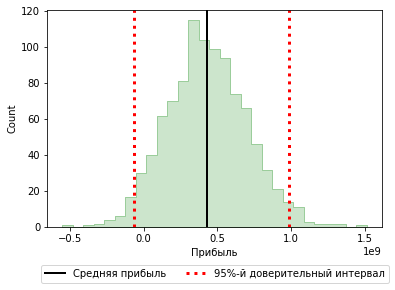

In [30]:
bootstrap_profits(true_values_geo_0, pd.Series(preds_geo_0, index=true_values_geo_0.index))

+------------------------+------------------+
|       Показатель       |     Значение     |
+------------------------+------------------+
|    Средняя прибыль     |    450.1 млн     |
|          Риск          |       1.0%       |
| Доверительный интервал | 44.6 : 830.8 млн |
+------------------------+------------------+


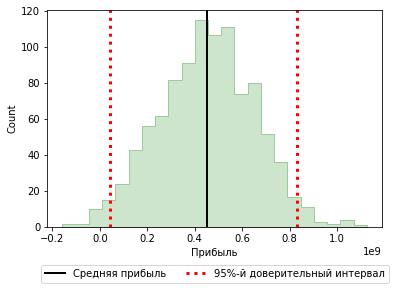

In [31]:
bootstrap_profits(true_values_geo_1, pd.Series(preds_geo_1, index=true_values_geo_1.index))

+------------------------+--------------------+
|       Показатель       |      Значение      |
+------------------------+--------------------+
|    Средняя прибыль     |     392.1 млн      |
|          Риск          |        8.7%        |
| Доверительный интервал | -147.3 : 876.9 млн |
+------------------------+--------------------+


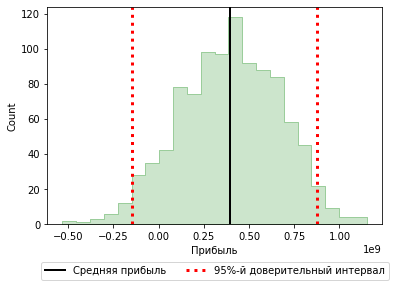

In [32]:
bootstrap_profits(true_values_geo_2, pd.Series(preds_geo_2, index=true_values_geo_2.index))

**Вывод:**

1. Обнаружено, что необходимый объем сырья для безубыточной скважины составляет 111,000 баррелей, что превышает средние значения прогнозируемых запасов сырья в каждом регионе.


2. В регионе 0 выявлен потенциал максимальной прибыли от 200 скважин, оцененный в 3,492.3 млрд.


3. Проведен анализ 95%-го доверительного интервала, который для региона 0 составляет от -90.2 до 923.1 млн, для региона 1 - от 59.6 до 868.8 млн, и для региона 2 - от -132.2 до 898.4 млн.


4. В результате исследования рисков выявлено, что регион 1 является менее рискованным с риском убытков всего лишь в 1.7%. Именно этот регион рекомендуется для приоритетного рассмотрения в плане разработки буровых скважин.


5. Регион 1 отличается наивысшей оценкой прибыли от 200 скважин при минимальном риске, всего 1.7%. Рекомендуется провести более детальное исследование этого региона с возможностью улучшения точности модели прогнозирования.